#### Search for the scenarios that has a specific tag in it.

In [ ]:
import os
from parser.scenario import get_scenario

scenario_path = '/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios/'
scenario_name = 'USA_US101-3_1_T-1.xml'
scenario, planning_problem, _ = get_scenario(scenario_path, scenario_name)

selected = []
target_tags = [
            'CRITICAL',
            # 'EVASIVE',
            # 'ILLEGAL_CUTIN',
            # 'EMERGENCY_BRAKING',
            # 'CUT_IN'
]

for sc in os.listdir(scenario_path):
      scenario, _, _ = get_scenario(scenario_path, sc)
      # print(scenario.scenario_id.__str__())
      tags = list(scenario.tags)
      for t in tags:
            # print(t)
            if t.name in target_tags:
                  selected.append(scenario.scenario_id.__str__())
                  break

#### Analyze the criticality of scenarios. Can be either sequential or parallel. Parallel processing is no recommended (hard to debug).

In [ ]:
import commonroad_crime.utility.batch_evaluation as utils_batch
from commonroad_crime.measure import (TTCStar, TTB, TTS, TTR, BTN, PET, ALongReq, ALatReq, STN, TET, TIT, DA, P_MC, SOI, P_SRS, P_SMH)
import os

scenario_path = os.getcwd() + "/scenarios_modified/"
config_path = os.getcwd() + "/config_files/"

utils_batch.run_sequential(
      scenario_path, config_root=config_path, measures=[P_SMH], verbose=True
)

# utils_batch.run_parallel(
#       scenario_path, config_root=config_path, measures=[P_SRS], verbose=True
# )


#### Planning trajectories for ego vehicles and modifying the scenarios to contain the ego vehicle and its trajectory. Store a csv file containing generated obstacle ids.

In [ ]:
import os
import pandas as pd
from commonroad_rp.utility.evaluation import create_full_solution_trajectory
from commonroad_rp.reactive_planner import ReactivePlanner
from commonroad_route_planner.route_planner import RoutePlanner
from commonroad_rp.utility.config import ReactivePlannerConfiguration
from commonroad.scenario.state import InitialState
from commonroad.scenario.obstacle import DynamicObstacle, ObstacleType
from commonroad.prediction.prediction import TrajectoryPrediction
from commonroad.geometry.shape import Rectangle
from commonroad.common.file_writer import CommonRoadFileWriter, OverwriteExistingFile


dir = "/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios"
config_file = "reactive_planner_config.yaml"
save_dir = "/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios_modified"

scenario_ego_id = {
      'scenario': [],
      'ego_id': []
}

for sc in os.listdir(dir):
      if sc.endswith(".xml"):
            # sc_path = os.path.join(dir, sc)
            
            print(f"Planning for {sc}")
            
            config = ReactivePlannerConfiguration.load(os.getcwd() + "/config/" + config_file, sc)
            config.update()            
            
            try:
                  # run route planner
                  route_planner = RoutePlanner(config.scenario, config.planning_problem)
                  route = route_planner.plan_routes().retrieve_first_route()

                  # get reference path
                  reference_path = route.reference_path
                  
                  planner = ReactivePlanner(config=config)

                  # set reference path for curvilinear coordinate system
                  planner.set_reference_path(route.reference_path)
                  
                  while not planner.goal_reached():
                        current_count = len(planner.record_state_list)
                        # check if planning cycle or not
                        plan_new_trajectory = current_count % config.planning.replanning_frequency == 0

                        # new planning cycle -> plan a new optimal trajectory
                        if plan_new_trajectory:
                              # set velocity
                              planner.set_desired_velocity(current_speed=planner.x_0.velocity)

                              # call plan function
                              optimal = planner.plan()

                              # record planned state and input
                              planner.record_state_and_input(optimal[0].state_list[1])

                              # reset planner state for re-planning
                              planner.reset(initial_state_cart=planner.record_state_list[-1], 
                                          initial_state_curv=(optimal[2][1], optimal[3][1]),
                                          collision_checker=planner.collision_checker, 
                                          coordinate_system=planner.coordinate_system)

                        # simulate scenario one step forward with planned trajectory
                        else:
                              # continue on optimal trajectory
                              temp = current_count % config.planning.replanning_frequency

                              # record state and input
                              planner.record_state_and_input(optimal[0].state_list[1 + temp])

                              # reset planner state for re-planning
                              planner.reset(initial_state_cart=planner.record_state_list[-1],
                                          initial_state_curv=(optimal[2][1 + temp], optimal[3][1 + temp]),
                                          collision_checker=planner.collision_checker, 
                                          coordinate_system=planner.coordinate_system)
            except Exception as e:
                  print(f"Scenario {sc} failed!")
                  continue
                        
            ego_solution_trajectory = create_full_solution_trajectory(config, planner.record_state_list)
            
            dynamic_obstacle_initial_state = InitialState(
                  position=config.planning_problem.initial_state.position,
                  orientation=config.planning_problem.initial_state.orientation,
                  velocity=config.planning_problem.initial_state.velocity,
                  time_step=config.planning_problem.initial_state.time_step,
                  yaw_rate=0,
                  slip_angle=0,
            )
            
            dynamic_obstacle_shape = Rectangle(width=1.8, length=4.3)
            dynamic_obstacle_prediction = TrajectoryPrediction(
                  ego_solution_trajectory, dynamic_obstacle_shape
            )
            
            # generate the dynamic obstacle according to the specification
            dynamic_obstacle_id = config.scenario.generate_object_id()
            dynamic_obstacle_type = ObstacleType.CAR
            ego_vehicle = DynamicObstacle(
                  dynamic_obstacle_id,
                  dynamic_obstacle_type,
                  dynamic_obstacle_shape,
                  dynamic_obstacle_initial_state,
                  dynamic_obstacle_prediction,
            )
            
            config.scenario.add_objects(ego_vehicle)
            
            fw = CommonRoadFileWriter(
                  config.scenario,
                  config.planning_problem_set,
                  config.scenario.author,
                  config.scenario.affiliation,
                  config.scenario.source,
                  config.scenario.tags
            )
            
            fw.write_to_file(os.path.join(save_dir, sc), OverwriteExistingFile.ALWAYS)
            
            scenario_ego_id['scenario'].append(sc)
            scenario_ego_id["ego_id"].append(dynamic_obstacle_id)

sc_ego_id_df = pd.DataFrame(scenario_ego_id)
sc_ego_id_df.to_csv('scenario_ego_id.csv')

#### Write yaml files for all planned scenarios containing the ego id for each scenario for further processing by CriMe.

In [ ]:
import pandas as pd
import yaml
import os

csv_file = os.getcwd() + '/scenario_ego_id.csv'
df = pd.read_csv(csv_file)

for index, row in df.iterrows():
    scenario_name = row['scenario'] 
    ego_id = row['ego_id'] 

    yaml_content = {
        'vehicle': {
            'ego_id': ego_id
        }
    }

    yaml_file_path = os.path.join(os.getcwd() + '/config_files/', f"{scenario_name[:-4]}.yaml")

    with open(yaml_file_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file)

    print(f"Written {yaml_file_path}")

#### Visualizing the parsed obstacles

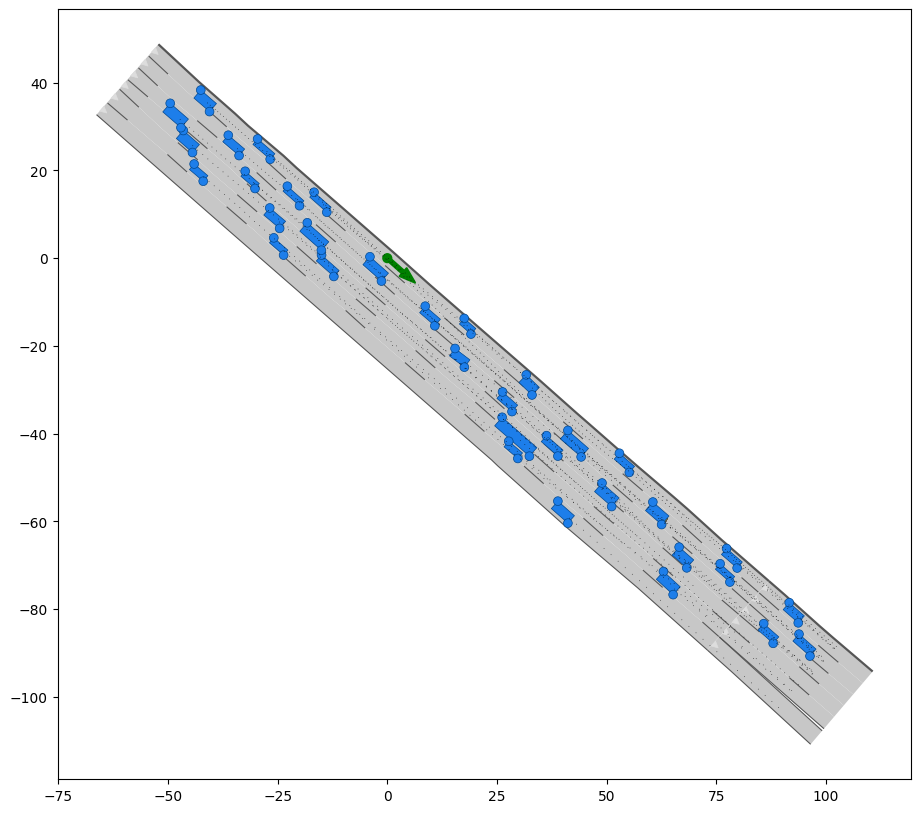

In [3]:
from math import inf
from commonroad.geometry.shape import Circle
from math import inf
import numpy as np
import matplotlib.pyplot as plt
from parser.scenario import get_scenario
from parser.parser import Parser
from commonroad.common.util import Interval
from commonroad.visualization.mp_renderer import MPRenderer

scenario_path = '/home/kareem/my-frenet/FrenetOptimalTrajectory/scenarios/'
scenario_name = 'USA_US101-3_1_T-1.xml'
scenario, planning_problem, _ = get_scenario(scenario_path, scenario_name)

parser = Parser(scenario=scenario, planning_problem=planning_problem,\
                  x_interval=Interval(-inf, inf), y_interval=Interval(-inf, inf))

obs = parser.parse_obstacles(time_step=0)

plt.figure(figsize=(25, 10))
renderer = MPRenderer()

scenario.draw(renderer)
planning_problem.draw(renderer)

for o in obs:
      circle_1 = Circle(radius=1, center=np.array([*o[:2]]))
      circle_2 = Circle(radius=1, center=np.array([*o[2:]]))
      circle_1.draw(renderer)
      circle_2.draw(renderer)

plt.gca().set_aspect('equal')
plt.margins(0, 0)
renderer.render()
plt.show()

#### Changing the planning problem of critical scenarios to add a goal location (the last state in the trajectories of the planned scenarios)

In [1]:
from parser.scenario import get_scenario
from commonroad.planning.goal import GoalRegion
from commonroad.common.util import Interval, AngleInterval
from commonroad.scenario.state import CustomState
from commonroad.geometry.shape import Rectangle
from commonroad.common.file_writer import CommonRoadFileWriter, OverwriteExistingFile
import yaml
import os

org_scenario_path = '/home/kareem/my-frenet/FrenetOptimalTrajectory/critical_analysis/Critical_Orginal'
planned_scenario_path = '/home/kareem/my-frenet/FrenetOptimalTrajectory/critical_analysis/Critical_Planned'
save_dir = '/home/kareem/my-frenet/FrenetOptimalTrajectory/critical_analysis/Critical_PP_Mod'
done = ['RUS_Bicycle-4_2_T-1.xml', 'RUS_Bicycle-9_1_T-1.xml']

for sc in os.listdir(org_scenario_path):
      if sc.endswith(".xml"):
            if sc not in done:
                  org_scen, org_pp, pp_set = get_scenario(org_scenario_path, sc)
                  plan_scen, plan_pp, _ = get_scenario(planned_scenario_path, sc)
                  
                  with open(os.path.join(os.getcwd() + '/config_files/', f"{sc[:-4]}.yaml"), 'r') as yaml_file:
                        data = yaml.safe_load(yaml_file)
                  
                  ego = plan_scen.obstacle_by_id(data['vehicle']['ego_id'])
                  goal_state = ego.state_at_time(time_step=33)
                  
                  goal_cs = CustomState()
                  goal_cs.add_attribute(new_attr='time_step')
                  goal_cs.add_attribute(new_attr='position')
                  goal_cs.add_attribute(new_attr='velocity')
                  goal_cs.add_attribute(new_attr='orientation')
                  
                  goal_cs.time_step = Interval(start=33, end=33)
                  goal_cs.position = Rectangle(length=2, width=1, center=goal_state.position)
                  goal_cs.velocity = Interval(start=goal_state.velocity, end=goal_state.velocity)
                  goal_cs.orientation = AngleInterval(start=goal_state.orientation, end=goal_state.orientation)
                  
                  goal_region = GoalRegion(state_list=[goal_cs])
                  org_pp.goal = goal_region
                  
                  fw = CommonRoadFileWriter(
                  org_scen,
                  pp_set,
                  org_scen.author,
                  org_scen.affiliation,
                  org_scen.source,
                  org_scen.tags
                  )
            
                  fw.write_to_file(os.path.join(save_dir, sc), OverwriteExistingFile.ALWAYS)
                      
            else:
                  continue


<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP / Specified traffic sign ID: 274
<FileReader>: Unknown TrafficElementID! Default traffic sign ID is used. Specified country: ESP /